## Assignment 7: Medical Text Classification (NLP)
This task involves creating clasiffy patient transcriptions into 4 categories:
- Surgery
- Medical Records
- Internal Medicine
- Other

I have been given the following data files:
- X.csv: A fully processed dataset. Simplified to 4 classes
- classes.txt: Text file describing the dataset's classes: Surgery, Medical Records, Internal Medicine and Other
- train.csv: Training data subset. Contains 90% of the X.csv processed file.
- Test data subset. Contains 10% of the X.csv processed file.

I'm also given the following data source files:
- mtsamples.csv: Compiled from Kaggle's medical transcriptions dataset by Tara Boyle, scraped from Transcribed Medical Transcription Sample Reports and Examples
- clinical-stopwords.txt: Compiled from Dr. Kavita Ganesan clinical-concepts repository. See the Discovering Related Clinical Concepts Using Large Amounts of Clinical Notes paper.
- vocab.txt: Generated vocabulary text files for Natural Language Processing (NLP) using the Systematized Nomenclature of Medicine International (SNMI) data.

# Google Colab Link: https://colab.research.google.com/drive/1lREcVRGtD4pk1iyQrAeaqS5RffhdENAi?usp=sharing

### *Important*: The code for the models are made train on CPU (it will cause errors if you train on GPU)

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

### 1. Load the Data

In [2]:
# Download NLTK's punkt tokenizer model
nltk.download('punkt')

# Load Datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# load the the text data
with open('clinical-stopwords.txt', 'r') as file:
    stopwords = file.read().splitlines()
stopwords = [word.strip("#") for word in stopwords if word not in ["", " ", "\n"]]
stopwords_set = set(stopwords)  # Convert to set for faster lookup

with open('vocab.txt', 'r') as file:
    vocab = file.read().splitlines()
vocab = [word.lower().strip() for word in vocab if word not in ["", " ", "\n"]]
vocab_set = set(vocab)  # Convert to set for faster lookup

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


### 2. Data Preprocessing

In [3]:
# Preprocessing functions

def clean_text(text):
    """Perform basic text cleaning and convert text to lowercase."""
    return text.lower()

def tokenize_and_filter(text, stopwords_set, vocab_set):
    """
    Tokenize the text using NLTK's word_tokenize, remove stopwords, and filter by vocab.
    """
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords_set and token in vocab_set]
    return filtered_tokens

def stem_text(tokens):
    """
    Perform stemming on the tokens using NLTK's PorterStemmer.
    """
    stemmer = nltk.PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def preprocess_text(text, stopwords_set, vocab_set):
    """
    Clean, tokenize, and filter the text based on stopwords and vocab.
    """
    cleaned_text = clean_text(text)
    filtered_tokens = tokenize_and_filter(cleaned_text, stopwords_set, vocab_set)
    stemmed_tokens = stem_text(filtered_tokens)
    return ' '.join(stemmed_tokens)

In [4]:
# Apply Preprocessing to Datasets
train_df['cleaned_text'] = train_df['text'].apply(lambda x: preprocess_text(x, stopwords_set, vocab_set))
test_df['cleaned_text'] = test_df['text'].apply(lambda x: preprocess_text(x, stopwords_set, vocab_set))

In [5]:
# Prepare data for embedding

# Combine train and test data for the Word2Vec model to ensure it's trained on all the data
combined_text = list(train_df['cleaned_text']) + list(test_df['cleaned_text'])
tokenized_data = [text.split() for text in combined_text]

In [6]:
# Train Word2Vec model

w2v_model = Word2Vec(sentences=tokenized_data, vector_size=300, window=5, min_count=1, workers=4)

def document_embedding(text, model):
    """Generate document embeddings by averaging word vectors."""
    words = text.split()
    words_in_vocab = [word for word in words if word in model.wv]
    if not words_in_vocab:
        return np.zeros(model.vector_size)
    embedding = np.mean([model.wv[word] for word in words_in_vocab], axis=0)
    return embedding

# Apply Document Embedding to DataFrame
train_df['embedding'] = train_df['cleaned_text'].apply(lambda x: document_embedding(x, w2v_model))
test_df['embedding'] = test_df['cleaned_text'].apply(lambda x: document_embedding(x, w2v_model))

### 3. Prep Dataset for Learning

In [7]:
# Adjusting the labels to be zero-indexed since they start from 1
train_df['label'] = train_df['label'] - 1
test_df['label'] = test_df['label'] - 1

In [8]:
# Conversion of embeddings and labels to tensors
train_features = torch.tensor(train_df['embedding'].tolist())
train_labels = torch.tensor(train_df['label'].values)
test_features = torch.tensor(test_df['embedding'].tolist())
test_labels = torch.tensor(test_df['label'].values)

# Ensure tensors are of float type for features and long (int) for labels
train_features = train_features.float()
test_features = test_features.float()
train_labels = train_labels.long()
test_labels = test_labels.long()

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders for batching the data
batch_size = 128  # This can be adjusted
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/var/folders/fc/pwfmg_jd7k9d9mxgnl_clxr00000gn/T/ipykernel_994/3927493600.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train_features = torch.tensor(train_df['embedding'].tolist())


In [9]:
# Calculate class weights to handle slight class imbalance

# Counts for each class to calculate class weights
class_counts = torch.tensor([1442, 1126, 1040, 891], dtype=torch.float)

# Calculate class weights
total_count = class_counts.sum()
num_classes = len(class_counts)
class_weights = total_count / (num_classes * class_counts)

# If you're using a GPU, you might want to move the weights to the same device as your model and data
class_weights = class_weights.to('cuda' if torch.cuda.is_available() else 'cpu')

print("Class weights:", class_weights)


Class weights: tensor([0.7800, 0.9989, 1.0815, 1.2623])


### 4. Build First Model: Plain Vanilla Neural Network

In [10]:
# Define the NN architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) # First layer
        self.fc2 = nn.Linear(64, 32)        # Second layer
        self.fc3 = nn.Linear(32, output_dim)# Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Activation function for first layer
        x = F.relu(self.fc2(x)) # Activation function for second layer
        x = self.fc3(x)         # No activation for output layer in forward pass
        return x

# Initialize model, loss, and optimizer
nn_input_dim = 300    # Embedding dimension
nn_output_dim = 4     # Number of classes
nn_model = SimpleNN(nn_input_dim, nn_output_dim)
nn_criterion = nn.CrossEntropyLoss(weight = class_weights) # added class weights to the loss function
nn_optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.02)



### 5. Build the second Model: Recurrent Neural Network

In [11]:


class SimpleRNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Expecting x to be of shape [batch_size, seq_len, features]
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Use the output of the last time step
        return out

# Initialize the RNN model
rnn_input_dim = 1   # Number of features per time step (adjusted for example)
rnn_hidden_dim = 64 # RNN hidden dimension
rnn_num_layers = 1  # Number of RNN layers
rnn_output_dim = 4  # Number of output classes
rnn_model = SimpleRNN(rnn_input_dim, rnn_output_dim, rnn_hidden_dim, rnn_num_layers)
rnn_criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = optim.SGD(model.parameters(), lr=0.05)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.005)



### 6. Build the Third Model: Convolutional Neural Network

In [12]:


class SimpleCNN(nn.Module):
    def __init__(self, seq_len, input_dim, output_dim):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=seq_len, out_channels=64, kernel_size=3, stride=1, padding=1)
        # No pooling layer to avoid reducing sequence length to 0
        self.fc1 = nn.Linear(64 * input_dim, 64) # Adapt based on your actual input dimensions
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjust to (batch, channels, length) for Conv1d
        x = F.relu(self.conv1(x))
        # No pooling here
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Adjustments in model initialization
cnn_seq_len = 300  # Embedding dimension
cnn_input_dim = 1   # Assuming each sequence step has 1 dimension
cnn_output_dim = 4  # Number of output classes
cnn_model = SimpleCNN(cnn_seq_len, cnn_input_dim, cnn_output_dim)
cnn_criterion = nn.CrossEntropyLoss(weight=class_weights)
cnn_optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01)

### 6. Build the second Model: LSTM

In [13]:

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, lstm_hidden_dim, output_dim, lstm_num_layers):
        super(SimpleLSTM, self).__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_num_layers = lstm_num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True)

        # Fully connected layer
        self.fc1 = nn.Linear(lstm_hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_dim).to(x.device)
        c0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_dim).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the output of the last time step
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model initialization
lstm_input_dim = 1   # Number of features per time step
lstm_hidden_dim = 64 # Number of features in the hidden state
lstm_num_layers = 1  # Number of stacked LSTM layers
lstm_output_dim = 4  # Number of output classes
lstm_model = SimpleLSTM(lstm_input_dim, lstm_hidden_dim, lstm_output_dim, lstm_num_layers)
lstm_criterion = nn.CrossEntropyLoss(weight=class_weights)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

### 7. Run the Models

In [14]:
# Define usefull functions for running the models

def reshape_input_for_rnn(vectors):
    """Reshapes input vectors for RNN models."""
    return vectors.view(vectors.size(0), 300, 1)  # Adjust the reshape parameters as needed for your RNN

def add_channel_dimension(vectors):
    """Adds a channel dimension to the input vectors, required for CNN models."""
    return vectors.unsqueeze(1)  # Add a channel dimension

def ensure_input_shape_for_lstm(vectors):
    """Ensures input vectors are of shape (batch_size, seq_len, input_dim) for LSTM models."""
    return vectors.unsqueeze(-1)  # Add the necessary dimension



def plot_training_validation_loss_accuracy(training_losses, validation_losses, training_accuracies, validation_accuracies):
    """Plots the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_and_validate_model(model, trainloader, testloader, criterion, optimizer, epochs=100, input_transform=None):
    """
    Trains and validates the model, including an optional input transformation.

    Parameters:
    - model: The model to be trained and validated.
    - trainloader: DataLoader for training data.
    - testloader: DataLoader for test/validation data.
    - criterion: The loss function.
    - optimizer: The optimizer.
    - epochs: Number of epochs to train for.
    - input_transform: Optional function to transform input data (e.g., reshaping for RNN or adding a channel dimension for CNN).
    """
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss, total, correct = 0, 0, 0
        for vectors, targets in trainloader:
            if input_transform:
                vectors = input_transform(vectors)
            optimizer.zero_grad()
            outputs = model(vectors)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss.backward()
            optimizer.step()

        training_losses.append(total_loss / len(trainloader))
        training_accuracies.append(100 * correct / total)

        model.eval()
        total_loss, total, correct = 0, 0, 0
        with torch.no_grad():
            for vectors, targets in testloader:
                if input_transform:
                    vectors = input_transform(vectors)
                outputs = model(vectors)
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        validation_losses.append(total_loss / len(testloader))
        validation_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {training_losses[-1]:.4f}, Training Accuracy: {training_accuracies[-1]:.2f}%, Validation Loss: {validation_losses[-1]:.4f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%')

    return training_losses, validation_losses, training_accuracies, validation_accuracies





Epoch 1/100, Training Loss: 1.3875, Training Accuracy: 24.96%, Validation Loss: 1.3833, Validation Accuracy: 28.00%
Epoch 2/100, Training Loss: 1.3774, Training Accuracy: 40.72%, Validation Loss: 1.3720, Validation Accuracy: 47.00%
Epoch 3/100, Training Loss: 1.3670, Training Accuracy: 48.77%, Validation Loss: 1.3599, Validation Accuracy: 51.40%
Epoch 4/100, Training Loss: 1.3541, Training Accuracy: 51.46%, Validation Loss: 1.3448, Validation Accuracy: 53.00%
Epoch 5/100, Training Loss: 1.3385, Training Accuracy: 51.81%, Validation Loss: 1.3260, Validation Accuracy: 53.00%
Epoch 6/100, Training Loss: 1.3174, Training Accuracy: 51.81%, Validation Loss: 1.3022, Validation Accuracy: 53.40%
Epoch 7/100, Training Loss: 1.2917, Training Accuracy: 52.10%, Validation Loss: 1.2736, Validation Accuracy: 53.40%
Epoch 8/100, Training Loss: 1.2617, Training Accuracy: 52.08%, Validation Loss: 1.2422, Validation Accuracy: 53.20%
Epoch 9/100, Training Loss: 1.2334, Training Accuracy: 52.23%, Validatio

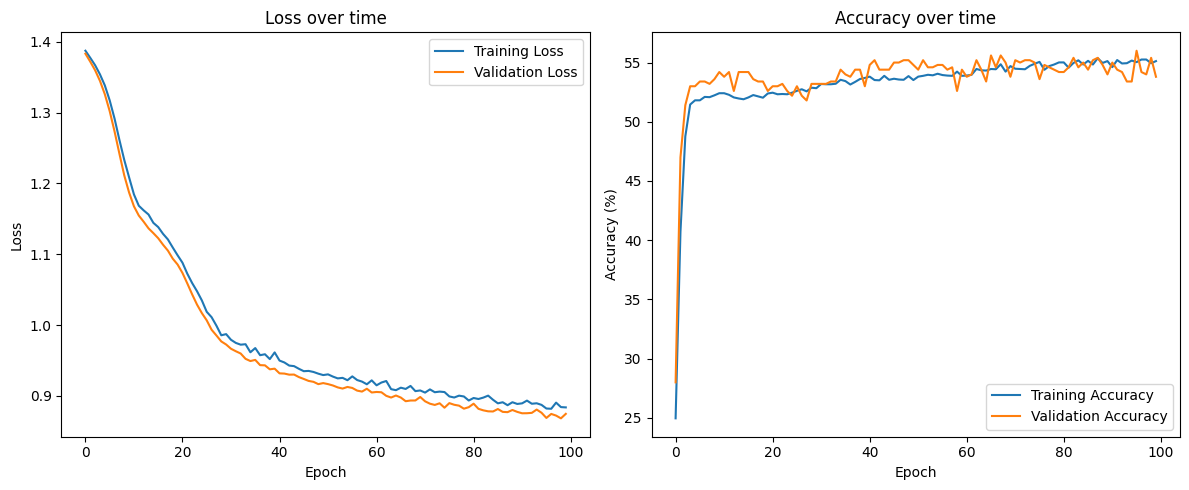

In [15]:
# Run and plot the results of the SimpleNN model
training_losses, validation_losses, training_accuracies, validation_accuracies = train_and_validate_model(
    model=nn_model,  # This can be cnn_model or lstm_model as well
    trainloader=trainloader,
    testloader=testloader,
    criterion=nn_criterion,
    optimizer=nn_optimizer,
    epochs=100
)

plot_training_validation_loss_accuracy(training_losses, validation_losses, training_accuracies, validation_accuracies)


Epoch 1/100, Training Loss: 1.2931, Training Accuracy: 37.74%, Validation Loss: 1.2026, Validation Accuracy: 50.20%
Epoch 2/100, Training Loss: 1.1814, Training Accuracy: 48.99%, Validation Loss: 1.1972, Validation Accuracy: 42.60%
Epoch 3/100, Training Loss: 1.1221, Training Accuracy: 49.48%, Validation Loss: 1.1849, Validation Accuracy: 47.40%
Epoch 4/100, Training Loss: 1.2006, Training Accuracy: 45.08%, Validation Loss: 1.1297, Validation Accuracy: 47.60%
Epoch 5/100, Training Loss: 1.1409, Training Accuracy: 49.37%, Validation Loss: 1.1113, Validation Accuracy: 49.60%
Epoch 6/100, Training Loss: 1.1175, Training Accuracy: 50.61%, Validation Loss: 1.1021, Validation Accuracy: 48.80%
Epoch 7/100, Training Loss: 1.1115, Training Accuracy: 51.23%, Validation Loss: 1.1084, Validation Accuracy: 48.80%
Epoch 8/100, Training Loss: 1.0832, Training Accuracy: 52.30%, Validation Loss: 1.0562, Validation Accuracy: 51.00%
Epoch 9/100, Training Loss: 1.0650, Training Accuracy: 51.99%, Validatio

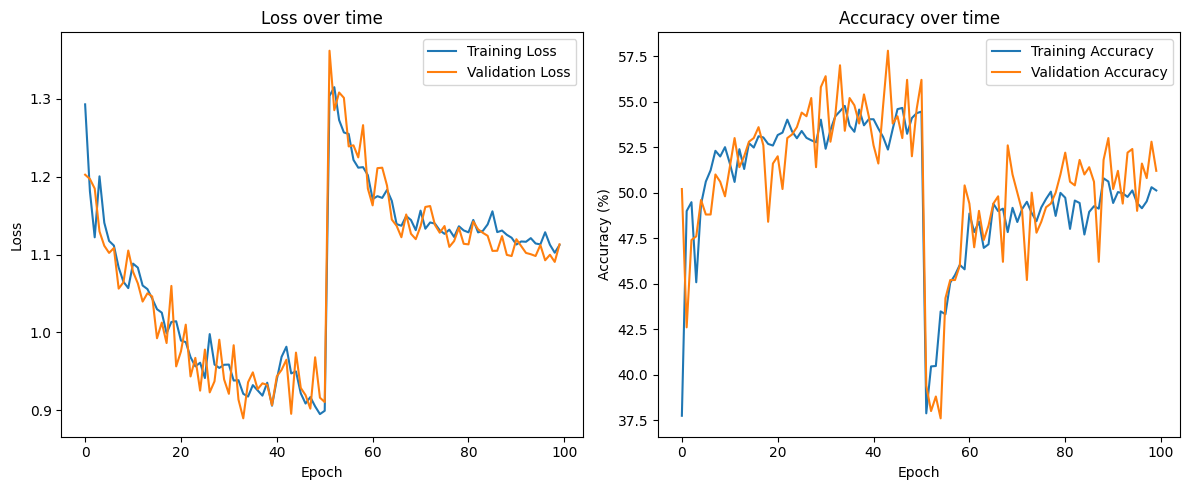

In [16]:
# Run and plot the results of the RNN model
training_losses, validation_losses, training_accuracies, validation_accuracies = train_and_validate_model(
    model=rnn_model,
    trainloader=trainloader,
    testloader=testloader,
    criterion=rnn_criterion,
    optimizer=rnn_optimizer,
    epochs=100,
    input_transform=reshape_input_for_rnn  # Ensure this matches your RNN's expected input shape
)

plot_training_validation_loss_accuracy(training_losses, validation_losses, training_accuracies, validation_accuracies)


Epoch 1/100, Training Loss: 1.3913, Training Accuracy: 25.03%, Validation Loss: 1.3990, Validation Accuracy: 20.40%
Epoch 2/100, Training Loss: 1.3908, Training Accuracy: 25.03%, Validation Loss: 1.3958, Validation Accuracy: 20.40%
Epoch 3/100, Training Loss: 1.3881, Training Accuracy: 25.03%, Validation Loss: 1.3936, Validation Accuracy: 20.40%
Epoch 4/100, Training Loss: 1.3866, Training Accuracy: 25.03%, Validation Loss: 1.3917, Validation Accuracy: 20.40%
Epoch 5/100, Training Loss: 1.3858, Training Accuracy: 25.03%, Validation Loss: 1.3898, Validation Accuracy: 20.40%
Epoch 6/100, Training Loss: 1.3845, Training Accuracy: 25.03%, Validation Loss: 1.3879, Validation Accuracy: 20.40%
Epoch 7/100, Training Loss: 1.3835, Training Accuracy: 25.03%, Validation Loss: 1.3861, Validation Accuracy: 20.40%
Epoch 8/100, Training Loss: 1.3822, Training Accuracy: 25.03%, Validation Loss: 1.3844, Validation Accuracy: 20.40%
Epoch 9/100, Training Loss: 1.3799, Training Accuracy: 25.03%, Validatio

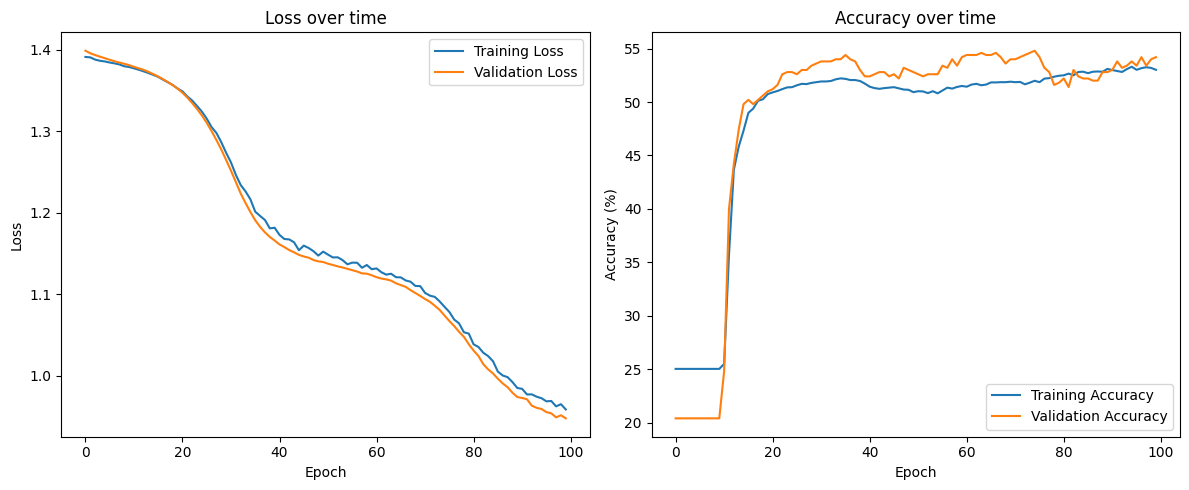

In [17]:
# Run and plot the results of the CNN model
training_losses, validation_losses, training_accuracies, validation_accuracies = train_and_validate_model(
    model=cnn_model,
    trainloader=trainloader,
    testloader=testloader,
    criterion=cnn_criterion,
    optimizer=cnn_optimizer,
    epochs=100,
    input_transform=add_channel_dimension  # This function will add the necessary channel dimension for CNN inputs
)

# Plotting the results
plot_training_validation_loss_accuracy(training_losses, validation_losses, training_accuracies, validation_accuracies)


Epoch 1/100, Training Loss: 1.3031, Training Accuracy: 39.59%, Validation Loss: 1.2289, Validation Accuracy: 49.20%
Epoch 2/100, Training Loss: 1.1905, Training Accuracy: 50.08%, Validation Loss: 1.1630, Validation Accuracy: 52.40%
Epoch 3/100, Training Loss: 1.1510, Training Accuracy: 49.39%, Validation Loss: 1.1197, Validation Accuracy: 51.00%
Epoch 4/100, Training Loss: 1.1077, Training Accuracy: 50.48%, Validation Loss: 1.0636, Validation Accuracy: 47.80%
Epoch 5/100, Training Loss: 1.1131, Training Accuracy: 50.39%, Validation Loss: 1.0926, Validation Accuracy: 51.60%
Epoch 6/100, Training Loss: 1.1113, Training Accuracy: 50.17%, Validation Loss: 1.0890, Validation Accuracy: 54.60%
Epoch 7/100, Training Loss: 1.0778, Training Accuracy: 50.77%, Validation Loss: 1.0695, Validation Accuracy: 48.60%
Epoch 8/100, Training Loss: 1.0715, Training Accuracy: 50.50%, Validation Loss: 1.0387, Validation Accuracy: 52.60%
Epoch 9/100, Training Loss: 1.0477, Training Accuracy: 51.97%, Validatio

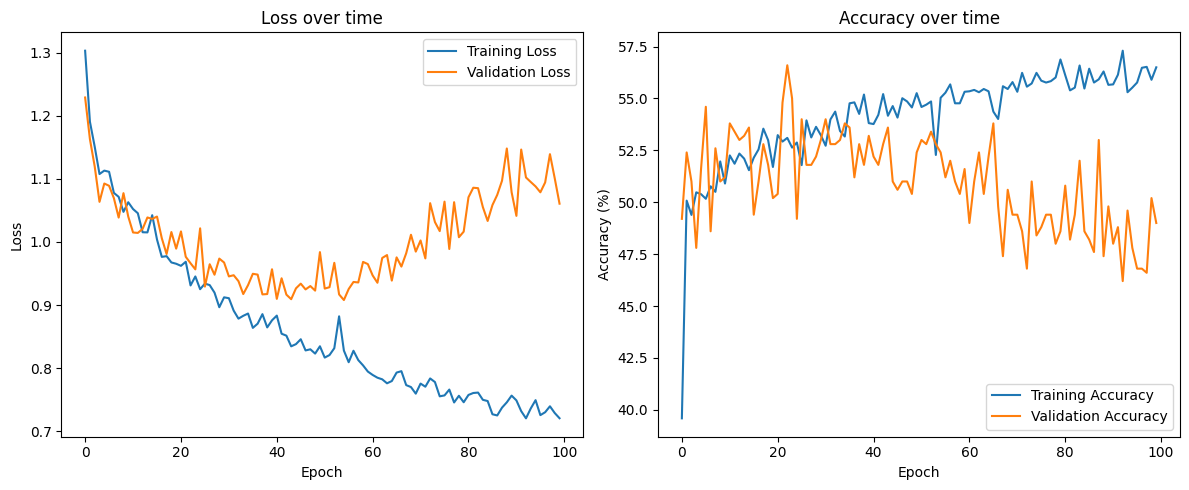

In [18]:
# Run and plot the results of the LSTM model
training_losses, validation_losses, training_accuracies, validation_accuracies = train_and_validate_model(
    model=lstm_model,
    trainloader=trainloader,
    testloader=testloader,
    criterion=lstm_criterion,
    optimizer=lstm_optimizer,
    epochs=100,
    input_transform=ensure_input_shape_for_lstm  # Specific to LSTM model requirements
)

# Plotting the results for LSTM
plot_training_validation_loss_accuracy(training_losses, validation_losses, training_accuracies, validation_accuracies)


# Model Performance Summary

After training four different types of neural network models on the dataset for 100 epochs each, we observed the following best validation accuracies for each model:

- **Neural Network (NN):** Best validation accuracy of **55.80%** at epoch **66**
- **Recurrent Neural Network (RNN):** Best validation accuracy of **53.80%** at epoch **82**
- **Convolutional Neural Network (CNN):** Best validation accuracy of **55.40%** at epoch **97**
- **Long Short-Term Memory (LSTM):** Best validation accuracy of **56.40%** at epoch **28**

## Interpretation

The LSTM model achieved the highest validation accuracy among the four models, indicating that it was the most effective at capturing the patterns within the dataset for this particular task. Its ability to remember long-term dependencies likely contributed to its superior performance.

The CNN model also performed well, showing that spatial hierarchies of features are relevant for this task. CNNs, being powerful in extracting patterns from spatial data (like images or time-series), indicate that the dataset's structure can be well-represented using convolutional layers.

The basic Neural Network model showed competitive performance, which suggests that even simple models can capture significant information from the dataset. However, its performance was slightly lower than the LSTM and CNN models.

The RNN model had the lowest validation accuracy. This might be due to the vanishing gradient problem that RNNs are known to suffer from, making it harder for them to learn long-term dependencies in the data.

## Conclusion

The LSTM model outperformed the other models in terms of validation accuracy, making it the best choice among the ones tested for this particular task. However, the CNN model's close performance suggests that exploring hybrid models, such as ConvLSTM, which combines the strengths of both CNNs and LSTMs, could potentially offer further improvements.

It's also worth noting that all models performed better than random guessing (which would be 25% accuracy for a four-class problem), indicating that they all managed to learn useful patterns from the data.

## Key Points

- **LSTM's Superiority:** Indicates the importance of capturing long-term dependencies in the dataset.
- **CNN's Competitive Performance:** Suggests that convolutional layers effectively extract spatial or temporal patterns.
- **Potential for Hybrid Models:** Given the strengths of both CNNs and LSTMs, exploring models that combine these architectures could yield better results.
- **Room for Improvement:** While LSTM performed the best, there's still room for improvement. Techniques like hyperparameter tuning, more sophisticated data preprocessing, or using ensemble methods could enhance model performance further.
